<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Debugging_for_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [2]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [4]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np


In [5]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

fatal: destination path 'grs34806-deep-learning-project-data' already exists and is not an empty directory.


Writing a function to read the simulated data and produce lists containing the sequences and a list of 0s and 1s.

In [6]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("seq"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]
  #print(labellist)
  assert len(datalist) == len(labellist) == len(seq_ids), "Lengths of lists don't match"

  print("Length of the datalist: ", len(datalist))
  print("Length of labellist: ", len(labellist))
  print("The number of positives in labellist: ", sum(labellist))
  for i in range(min(5, len(datalist))):
        print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  return datalist, labellist


In [7]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.seq",
posfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.pos")

Length of the datalist:  1000
Length of labellist:  1000
The number of positives in labellist:  507
ID: seq1, Has annotation: 1, Sequence length: 113
ID: seq2, Has annotation: 0, Sequence length: 166
ID: seq3, Has annotation: 0, Sequence length: 197
ID: seq4, Has annotation: 1, Sequence length: 150
ID: seq5, Has annotation: 0, Sequence length: 134


Splitting the lists into training and testing datasets using the train_test_split method from sklearn.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
def generate_train_test (datalist, labellist):
  traindatalist, testdatalist, trainlabellist, testlabellist = train_test_split(
      datalist, labellist, test_size=0.2, random_state=42
  )
  return traindatalist, testdatalist, trainlabellist, testlabellist

In [9]:
traindatalist, testdatalist, trainlabellist, testlabellist = generate_train_test(
    datalist, labellist
)
# Printing the length of the training and testing data
print("Training data size:", len(traindatalist))
print("Training labels size:", len(trainlabellist))
print("Test data size:", len(testdatalist))
print("Test labels size:", len(testlabellist))

Training data size: 800
Training labels size: 800
Test data size: 200
Test labels size: 200


Defined the provided functions.

In [10]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

In [11]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array

In [12]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))

In [13]:
from d2l import torch as d2l

The function also includes code for converting the tokenized seq into a 1-hot encoded representation so it can be fed as input to the CNN.

In [14]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num)
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  print("Shape of seq_array: ", seq_array.shape)
  print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        seq_onehotencoding.shape)
  return data_iter

In [15]:
train_iter = load_data(batch_size = 25, num_steps=100, dataset=traindatalist, trainlabels=trainlabellist)
test_iter = load_data(batch_size= 25, num_steps = 100, dataset = testdatalist, trainlabels = testlabellist)

Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])


Building the 1D-CNN model.

In [50]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=128,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=conv_channels,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(1, -1),
          nn.Linear(in_features = int(conv_channels*self.context_size/4),
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.6965, Test Loss: 0.7039, Test Accuracy: 0.4700
Epoch 2: Train Loss: 0.6890, Test Loss: 0.6901, Test Accuracy: 0.6550
Epoch 3: Train Loss: 0.6723, Test Loss: 0.6780, Test Accuracy: 0.5300
Epoch 4: Train Loss: 0.6362, Test Loss: 0.6375, Test Accuracy: 0.6950
Epoch 5: Train Loss: 0.5690, Test Loss: 0.6214, Test Accuracy: 0.6400
Epoch 6: Train Loss: 0.5209, Test Loss: 0.5683, Test Accuracy: 0.6350
Epoch 7: Train Loss: 0.4549, Test Loss: 0.4987, Test Accuracy: 0.7550
Epoch 8: Train Loss: 0.3987, Test Loss: 0.4729, Test Accuracy: 0.7600
Epoch 9: Train Loss: 0.3636, Test Loss: 0.4753, Test Accuracy: 0.8400
Epoch 10: Train Loss: 0.3328, Test Loss: 0.4147, Test Accuracy: 0.8450
Epoch 11: Train L

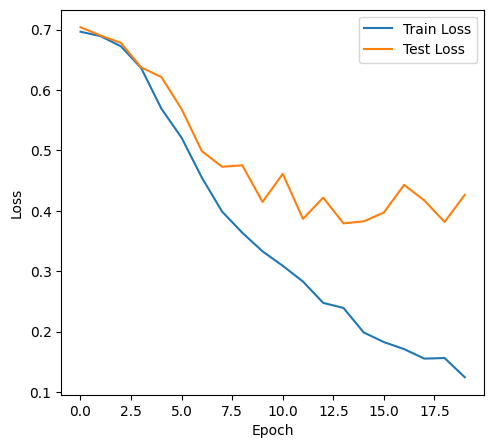

In [51]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 20

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing with a weight decay value of 1e-4, along with a learning rate of 1e-3 and a dropout rate of 0.5

Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.7052, Test Loss: 0.6898, Test Accuracy: 0.5300
Epoch 2: Train Loss: 0.6902, Test Loss: 0.6930, Test Accuracy: 0.4700
Epoch 3: Train Loss: 0.6845, Test Loss: 0.6869, Test Accuracy: 0.5300
Epoch 4: Train Loss: 0.6718, Test Loss: 0.6788, Test Accuracy: 0.5850
Epoch 5: Train Loss: 0.6371, Test Loss: 0.6514, Test Accuracy: 0.6550
Epoch 6: Train Loss: 0.5732, Test Loss: 0.5949, Test Accuracy: 0.6950
Epoch 7: Train Loss: 0.4874, Test Loss: 0.5501, Test Accuracy: 0.7300
Epoch 8: Train Loss: 0.4580, Test Loss: 0.5261, Test Accuracy: 0.7950
Epoch 9: Train Loss: 0.3799, Test Loss: 0.4467, Test Accuracy: 0.8250
Epoch 10: Train Loss: 0.3530, Test Loss: 0.4319, Test Accuracy: 0.8400
Epoch 11: Train L

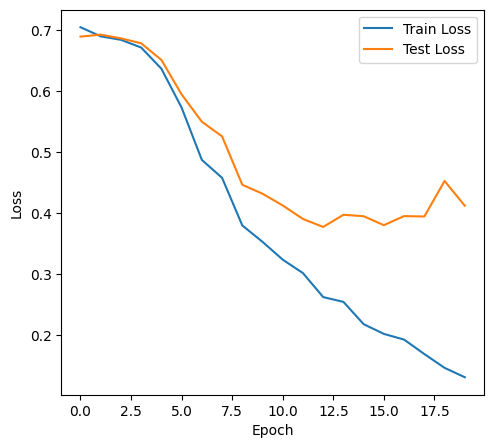

In [52]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 20
weight_decay = 1e-4

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay = weight_decay)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing with a dropout rate of 0.2, a lr of 0.001 and a weight_decay value of 0.001

Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.6946, Test Loss: 0.6948, Test Accuracy: 0.4700
Epoch 2: Train Loss: 0.6847, Test Loss: 0.6922, Test Accuracy: 0.4700
Epoch 3: Train Loss: 0.6730, Test Loss: 0.6791, Test Accuracy: 0.5400
Epoch 4: Train Loss: 0.6564, Test Loss: 0.6698, Test Accuracy: 0.6100
Epoch 5: Train Loss: 0.5989, Test Loss: 0.6330, Test Accuracy: 0.6850
Epoch 6: Train Loss: 0.5549, Test Loss: 0.5984, Test Accuracy: 0.7250
Epoch 7: Train Loss: 0.4904, Test Loss: 0.5448, Test Accuracy: 0.7650
Epoch 8: Train Loss: 0.4648, Test Loss: 0.5255, Test Accuracy: 0.8000
Epoch 9: Train Loss: 0.3951, Test Loss: 0.4786, Test Accuracy: 0.8400
Epoch 10: Train Loss: 0.3600, Test Loss: 0.4507, Test Accuracy: 0.8150
Epoch 11: Train L

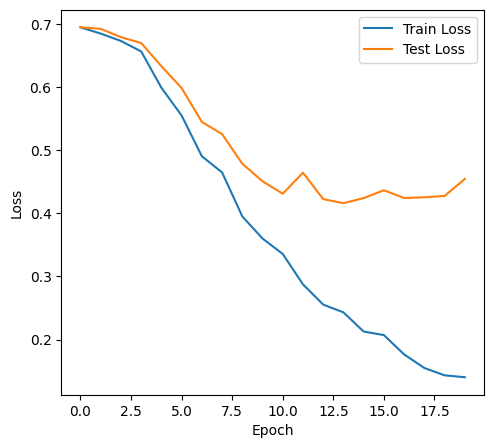

In [53]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 0.001
dropout_rate = 0.2
num_epochs = 20
weight_decay = 0.001

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay = weight_decay)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Implementing with SGD optimizer, to further try the performance of the model using momentum.

Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.6938, Test Loss: 0.6932, Test Accuracy: 0.5200
Epoch 2: Train Loss: 0.6935, Test Loss: 0.6933, Test Accuracy: 0.5050
Epoch 3: Train Loss: 0.6920, Test Loss: 0.6933, Test Accuracy: 0.5000
Epoch 4: Train Loss: 0.6935, Test Loss: 0.6930, Test Accuracy: 0.4850
Epoch 5: Train Loss: 0.6925, Test Loss: 0.6925, Test Accuracy: 0.4950
Epoch 6: Train Loss: 0.6939, Test Loss: 0.6927, Test Accuracy: 0.5050
Epoch 7: Train Loss: 0.6928, Test Loss: 0.6930, Test Accuracy: 0.5050
Epoch 8: Train Loss: 0.6933, Test Loss: 0.6929, Test Accuracy: 0.5000
Epoch 9: Train Loss: 0.6932, Test Loss: 0.6933, Test Accuracy: 0.5050
Epoch 10: Train Loss: 0.6929, Test Loss: 0.6934, Test Accuracy: 0.5050
Epoch 11: Train L

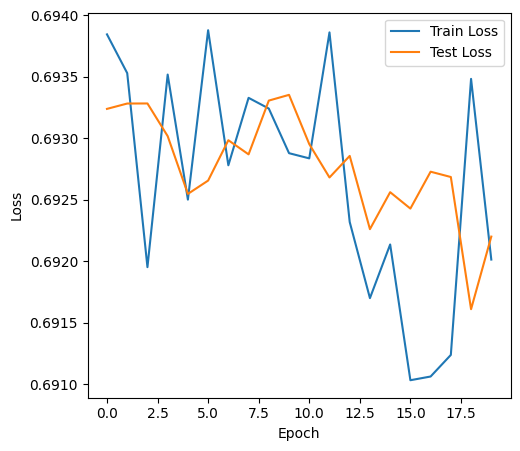

In [54]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 20
weight_decay = 1e-4
momentum = 0.5

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False,
    momentum = 0.5
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,
                              weight_decay = weight_decay, momentum=momentum)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [55]:
patience = 3  # number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)

        logits, loss = model(X, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_accuracy = correct / total
    train_losses.append(epoch_loss / len(train_iter))

    # Evaluate
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

    test_loss /= len(test_iter)
    test_losses.append(test_loss)
    test_accuracies.append(correct / total)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # Restore best model
            break


Epoch 1: Train Loss: 0.6918, Test Loss: 0.6921, Test Accuracy: 0.5450
Epoch 2: Train Loss: 0.6905, Test Loss: 0.6918, Test Accuracy: 0.5350
Epoch 3: Train Loss: 0.6901, Test Loss: 0.6922, Test Accuracy: 0.5400
Epoch 4: Train Loss: 0.6920, Test Loss: 0.6919, Test Accuracy: 0.5450
Epoch 5: Train Loss: 0.6903, Test Loss: 0.6919, Test Accuracy: 0.5250
Early stopping triggered at epoch 5


Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.6953, Test Loss: 0.6948, Test Accuracy: 0.4700
Epoch 2: Train Loss: 0.6870, Test Loss: 0.6862, Test Accuracy: 0.5300
Epoch 3: Train Loss: 0.6831, Test Loss: 0.6923, Test Accuracy: 0.4700
Epoch 4: Train Loss: 0.6683, Test Loss: 0.6872, Test Accuracy: 0.5300
Epoch 5: Train Loss: 0.6655, Test Loss: 0.6702, Test Accuracy: 0.5300
Epoch 6: Train Loss: 0.6455, Test Loss: 0.6666, Test Accuracy: 0.6350
Epoch 7: Train Loss: 0.6040, Test Loss: 0.6481, Test Accuracy: 0.6850
Epoch 8: Train Loss: 0.5563, Test Loss: 0.6180, Test Accuracy: 0.6800
Epoch 9: Train Loss: 0.4994, Test Loss: 0.5773, Test Accuracy: 0.6900
Epoch 10: Train Loss: 0.4590, Test Loss: 0.5621, Test Accuracy: 0.7200
Epoch 11: Train L

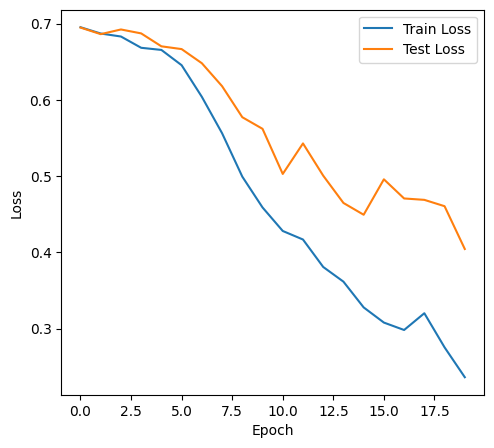

In [56]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 0.001
dropout_rate = 0.2
num_epochs = 20
weight_decay = 0.001

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay = weight_decay)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Modifying the CNN architecture to check for better performance using BatchNorm and using Kaiming initialization, which is used for networks with ReLU activation.

In [58]:
import torch.nn.init as init


In [59]:
class ProteinCNN1D_BatchNorm_Kaiming(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=128,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=conv_channels,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(1, -1),
          nn.Linear(in_features = int(conv_channels*self.context_size/4),
                    out_features = 1,
                    bias = use_bias)

      )

      self.init_weights()
  def init_weights(self):
        # Apply Kaiming initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='sigmoid')
                if m.bias is not None:
                    init.zeros_(m.bias)

  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss

Shape of seq_array:  torch.Size([800, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([800, 20, 100])
Shape of seq_array:  torch.Size([200, 100])
Shape of data_arrays, which now considers 
one-hot encoded sequence:  torch.Size([200, 20, 100])
Epoch 1: Train Loss: 0.8905, Test Loss: 0.6939, Test Accuracy: 0.4650
Epoch 2: Train Loss: 0.8022, Test Loss: 0.7029, Test Accuracy: 0.5400
Epoch 3: Train Loss: 0.7529, Test Loss: 0.7055, Test Accuracy: 0.5100
Epoch 4: Train Loss: 0.6940, Test Loss: 0.6850, Test Accuracy: 0.5700
Epoch 5: Train Loss: 0.6918, Test Loss: 0.6619, Test Accuracy: 0.5800
Epoch 6: Train Loss: 0.6629, Test Loss: 0.6575, Test Accuracy: 0.6050
Epoch 7: Train Loss: 0.5584, Test Loss: 0.6850, Test Accuracy: 0.5900
Epoch 8: Train Loss: 0.5626, Test Loss: 0.6967, Test Accuracy: 0.6200
Epoch 9: Train Loss: 0.5014, Test Loss: 0.6268, Test Accuracy: 0.6200
Epoch 10: Train Loss: 0.4650, Test Loss: 0.6315, Test Accuracy: 0.6350
Epoch 11: Train L

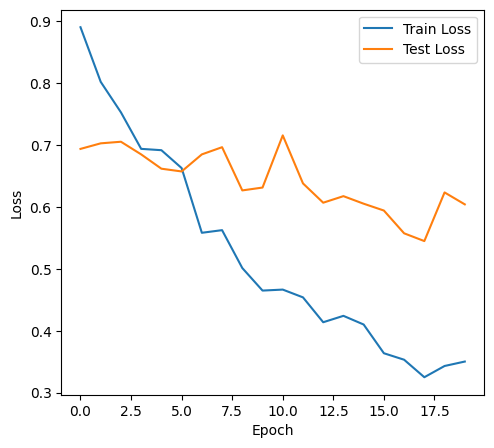

In [60]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 0.001
dropout_rate = 0.2
num_epochs = 20
weight_decay = 0.001

train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=traindatalist,
                       trainlabels=trainlabellist)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = testdatalist,
                      trainlabels = testlabellist)

# Initializing the model
model = ProteinCNN1D_BatchNorm_Kaiming(
    vocab_size=20,
    context_size=context_size,
    conv_channels=128,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay = weight_decay)

train_losses = []
test_losses = []
test_accuracies = []
#Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  #Evaluation on the test set
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        test_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
  test_losses.append(test_loss / len(test_iter))
  test_accuracies.append(correct/total)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()